In [1]:
import os.path

import scanpy as sc
import scanpy.external as sce
from flecs.utils import set_seed, get_project_root
import random
import numpy as np
from flecs.experimental_validation.utils import get_cell_indices, adapt_source_population_size, \
    compute_optimal_transport, compute_env_shortest_paths_with_ot, plot_cell_type_distribution
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(16, 8))
set_seed(0)

In [2]:
use_magic = True

## Load

In [3]:
adata = sc.read_h5ad(os.path.join(get_project_root(), 
                                  "datasets", "Paul15", "processed", "paul15_with_mouse_grn.h5ad")
                    )
# Restrict to relevant cell populations
adata = adata[adata.obs["Batch_desc"].apply(lambda n: n in ['Unsorted myeloid',
                                                            'CMP Flt3+ Csf1r+', 
                                                            'Cebpe KO', 
                                                            'Cebpa KO'])].copy()

## Highly variable genes

In [4]:
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

# Find highly variable genes
adata_copy = sc.pp.log1p(adata, copy=True)
sc.pp.highly_variable_genes(adata_copy, n_top_genes=4000, flavor='cell_ranger')  # Expects logged data

adata.var['highly_variable'] = adata_copy.var['highly_variable']


In [5]:
adata.var['highly_variable']["Cebpa"]

True

In [6]:
adata.var['highly_variable']["Cebpe"]

True

In [7]:
adata.var['highly_variable'].sum()

4000

In [8]:
if use_magic:
    sce.pp.magic(adata, t=3, n_pca=300, verbose=True)

Calculating MAGIC...
  Running MAGIC on 7296 cells and 11757 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.10 seconds.
    Calculating KNN search...
    Calculated KNN search in 21.92 seconds.
    Calculating affinities...
    Calculated affinities in 21.07 seconds.
  Calculated graph and diffusion operator in 47.10 seconds.
  Running MAGIC with `solver='exact'` on 11757-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 18.09 seconds.
Calculated MAGIC in 65.28 seconds.


In [9]:
adata = adata[:, adata.var['highly_variable']].copy()
# Renormalize after filtering
sc.pp.normalize_per_cell(adata)
adata.obs.reset_index(inplace=True)

## Compute cell paths

In [10]:
if use_magic:
    sc.tl.pca(adata, svd_solver="arpack", n_comps=200)
    sc.pp.neighbors(adata, n_neighbors=100, n_pcs=200)
    sc.tl.umap(adata, min_dist=0.3)
else:
    sc.tl.pca(adata, svd_solver="arpack", n_comps=200)
    sc.pp.neighbors(adata, n_neighbors=7, n_pcs=50)
    sc.tl.umap(adata, min_dist=0.3)

In [11]:
# Get cell indices coming from the different batches
cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells = get_cell_indices(adata)
random.seed(0)
random.shuffle(cmp_cells)
random.shuffle(unsorted_cells)
random.shuffle(cebpa_cells)
random.shuffle(cebpe_cells)

resampled_cmp_cells = adapt_source_population_size(cmp_cells, unsorted_cells)
ot_mapping = compute_optimal_transport(adata, resampled_cmp_cells, unsorted_cells)

unsorted_shortest_paths = compute_env_shortest_paths_with_ot(adata, "Unsorted myeloid")
cebpa_ko_shortest_paths = compute_env_shortest_paths_with_ot(adata, "Cebpa KO")
cebpe_ko_shortest_paths = compute_env_shortest_paths_with_ot(adata, "Cebpe KO")

# Convert keys to strings
unsorted_shortest_paths = {str(k): v for k, v in unsorted_shortest_paths.items()}
cebpa_ko_shortest_paths = {str(k): v for k, v in cebpa_ko_shortest_paths.items()}
cebpe_ko_shortest_paths = {str(k): v for k, v in cebpe_ko_shortest_paths.items()}

adata.uns["unsorted_shortest_paths"] = unsorted_shortest_paths
adata.uns["cebpa_ko_shortest_paths"] = cebpa_ko_shortest_paths
adata.uns["cebpe_ko_shortest_paths"] = cebpe_ko_shortest_paths

100%|███████████████████████████| 768/768 [00:16<00:00, 45.31it/s]


## Save

In [12]:
if use_magic:
    adata.write_h5ad(os.path.join(get_project_root(), 
                                  "datasets", "Paul15", "processed", "adata_processed_with_paths_magic.h5ad")
                )
else:
    adata.write_h5ad(os.path.join(get_project_root(), 
                                      "datasets", "Paul15", "processed", "adata_processed_with_paths.h5ad")
                )

## Plot

/Users/paul/miniconda3/envs/flecs/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


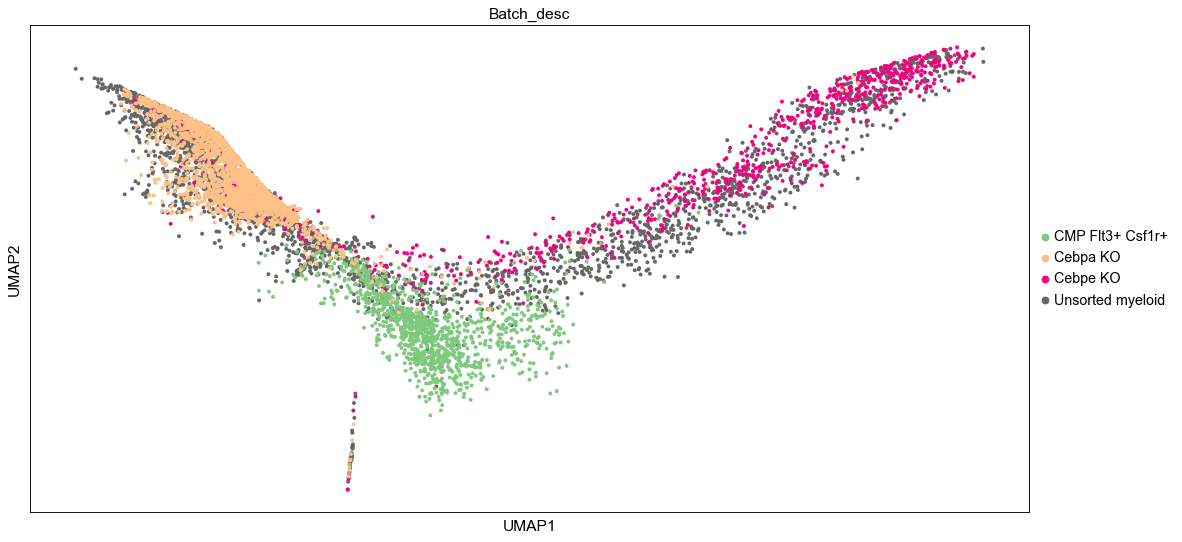

In [13]:
sc.pl.umap(adata, color="Batch_desc", palette="Accent", legend_loc='right margin', size=50)

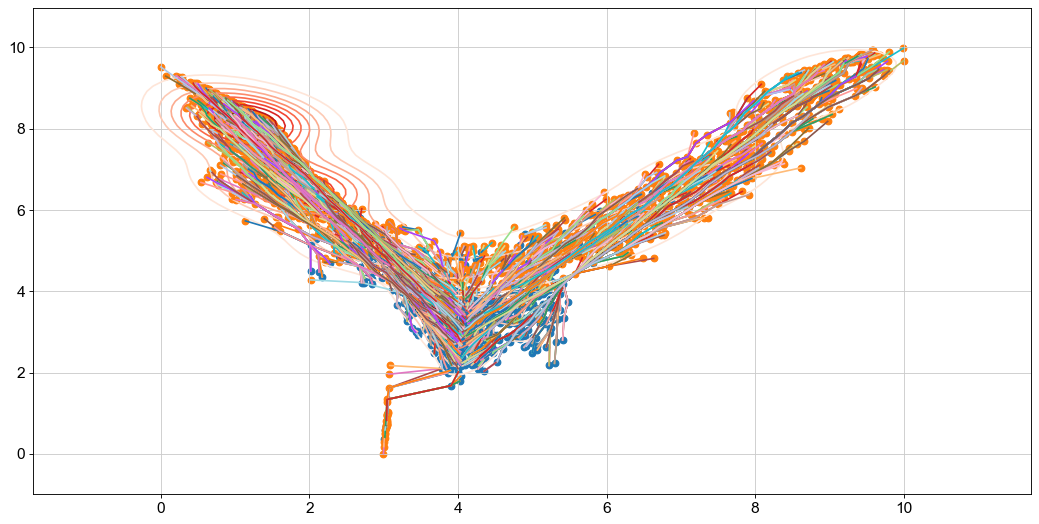

In [14]:
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+')
plot_cell_type_distribution(adata, 'Unsorted myeloid')

for path in unsorted_shortest_paths.values():
    path_coord = adata.obsm["X_umap"][path]
    plt.plot(path_coord[:, 0], path_coord[:, 1])

plt.show()

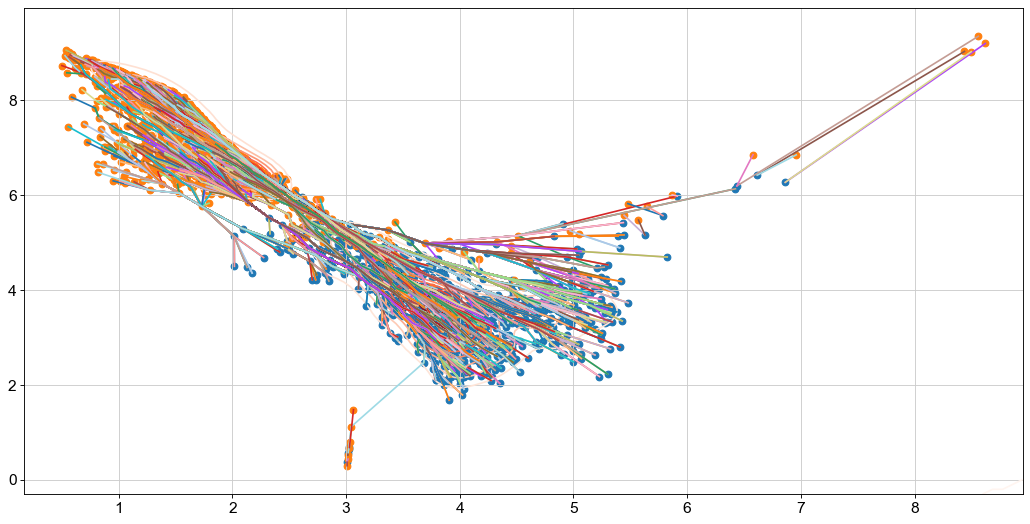

In [15]:
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+')
plot_cell_type_distribution(adata, 'Cebpa KO')

for path in cebpa_ko_shortest_paths.values():
    path_coord = adata.obsm["X_umap"][path]
    plt.plot(path_coord[:, 0], path_coord[:, 1])

plt.show()

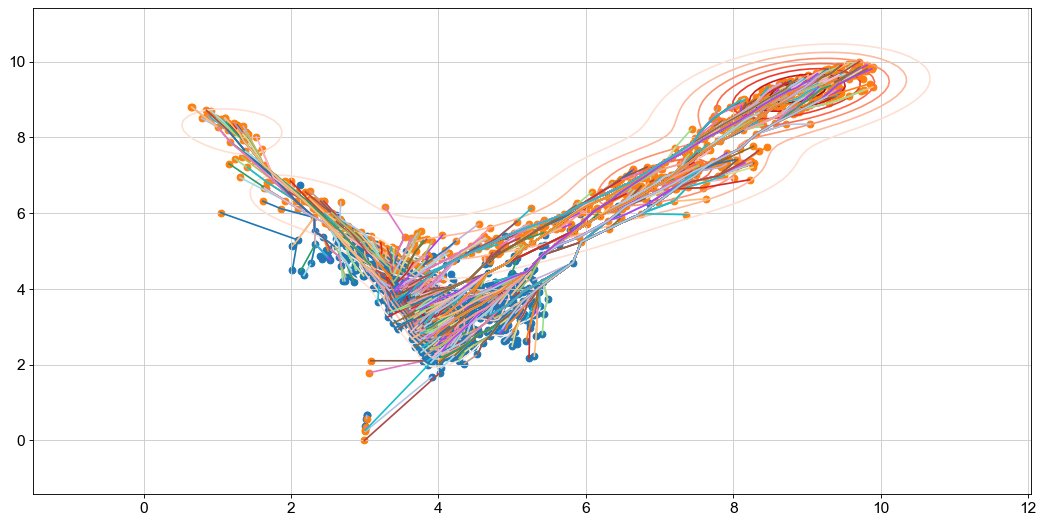

In [16]:
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+')
plot_cell_type_distribution(adata, 'Cebpe KO')

for path in cebpe_ko_shortest_paths.values():
    path_coord = adata.obsm["X_umap"][path]
    plt.plot(path_coord[:, 0], path_coord[:, 1])

plt.show()